In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.integrate import quad, trapz
import scipy.stats as stats

In [311]:
# Definición de variables eV

k = 1.380649e-23    # J / K
h = 6.62607015e-34  # J*s
h_bar = h/(2*np.pi) # J*s
m = 0.5*9.1e-31     # kg-
q = 1.602176634e-19    # C

Ec = -4.7 * q       # J
Ef = -5.0 * q       # J

L = 40e-9           # m
W = 3*L             # m

alfa = L*W*m/(np.pi*h_bar*h_bar)

C_g = 0.1e-15       # F 
C_q = q*q*m*W*L/(2*np.pi*h_bar*h_bar)   # F

C_es = C_g + C_q

eta_0 = 1.0
eta = C_g/C_es

V_t = (Ec-Ef)/(q)

# Parte I

In [226]:

# Funciones de cálculo
def get_g(E, Ec): # g(E)dE eq 2.47 pag 70
    return (E >= Ec)


def fermi_dirac(E, T):
    return np.piecewise(E, [E<0, E>=0], [lambda x: 1/(1 + np.exp(x/(k*T))), lambda x: np.exp(-x/(k*T))/(1 + np.exp(-x/(k*T)))] )



def get_N(E, U, T, Vds):
    return 0.5 * alfa * np.trapz(get_g(E-U, Ec) * (fermi_dirac(E-Ef, T) + fermi_dirac(E-(Ef-Vds*q), T)), x=E, axis=0)


def get_U(N, N_0, V_gs): # eq 5.33
    return q*q/C_g*(N-N_0)-V_gs*q


def get_I(E, U, T, Vds):
    y = np.sqrt(2*m*(E-Ec-U), where=E-Ec-U>=0) * get_g(E-U, Ec) * (fermi_dirac(E-Ef, T) - fermi_dirac(E-(Ef-Vds*q), T))
    return q*W / (np.pi*np.pi*h_bar*h_bar) * np.trapz(y, x=E, axis=0)


# Loop de autoconsistencia
def solve_I(Vds, T, Vgs, U_guess = -0.3*q, tol = 1e-5, lr = 1e-3, disable = False):
    
    E = np.linspace(Ec*2, 0, 10000)

    N_0 = get_N(E = E, U = 0, T = T, Vds = 0)
    # print(f"N_0 = {N_0}")
    
    U_array = []
    error = []

    for _ in tqdm(range(int(2000)), disable=disable):
        N_ = get_N(E, U_guess, T, Vds)
        # print(f"N = {N_}")
        U_formula = get_U(N_, N_0, Vgs)

        # print(f"U_={U_guess} \tU_computed={U_formula} \tN = {get_N(E, U_guess, T, Vds)}")

        U_array.append(U_guess)

        # print(U_)

        if abs(U_formula - U_guess) < tol:
            break
        
        U_guess = U_guess + lr*(U_formula - U_guess)
            # print(f"lr*error = {lr*(U_computed - U_)}")


        error.append(abs(U_formula - U_guess))
    
    I_ = get_I(E, U_guess, T, Vds)
    # plt.plot(np.array(error)/q)
    # plt.yscale('log')
    # plt.xscale('log')

    
    return I_, U_array


In [100]:
a[1]

[-4.806528e-20,
 -4.807451270404387e-20,
 -4.8083736175383703e-20,
 -4.809295042325219e-20,
 -4.8102155456872813e-20,
 -4.8111351285459814e-20,
 -4.812053791821823e-20,
 -4.8129715364343886e-20,
 -4.813827510871532e-20,
 -4.814682629334238e-20,
 -4.815536892678481e-20,
 -4.81639030175938e-20,
 -4.817242857431199e-20,
 -4.8180945605473453e-20,
 -4.8189454119603754e-20,
 -4.8197954125219926e-20,
 -4.820644563083048e-20,
 -4.821492864493542e-20,
 -4.822340317602626e-20,
 -4.8231869232586014e-20,
 -4.8240326823089207e-20,
 -4.824877595600189e-20,
 -4.825721663978166e-20,
 -4.8265648882877654e-20,
 -4.8274072693730555e-20,
 -4.8281868497232777e-20,
 -4.82896565049315e-20,
 -4.829743672462252e-20,
 -4.830520916409385e-20,
 -4.8312973831125707e-20,
 -4.832073073349053e-20,
 -4.832847987895299e-20,
 -4.8336221275269994e-20,
 -4.8343954930190677e-20,
 -4.835168085145644e-20,
 -4.8359399046800934e-20,
 -4.8367109523950085e-20,
 -4.8374812290622087e-20,
 -4.838250735452742e-20,
 -4.83901947233688

41.05072445564501 -0.31069875351612297


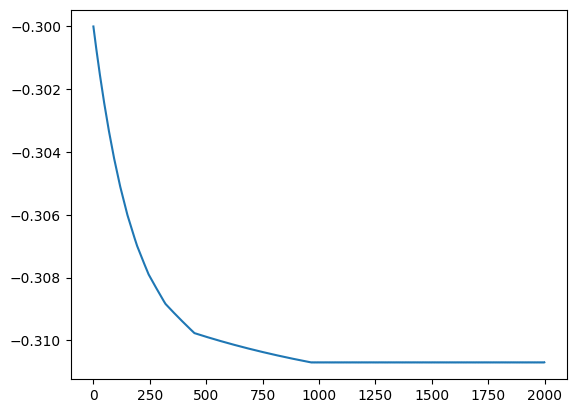

In [127]:
a = solve_I(Vds = 0.25,
        T = 298,
        Vgs = 0.5,
        lr = 0.001,
        tol = 1e-3*q)
# print(U,I*1e6)
print(a[0]*1e6, a[1][-1]/q)

plt.plot(np.array(a[1])/q)
# N_0 = get_N(-0.5*eta*q, 298, 0)
# print(N_0)
    # print(f"N_0 = {N_0}")

In [170]:
def plot_IVds(T, Vgs, tol = 1e-2*q, lr = 0.005):
    n = 100
    Vds_array = np.linspace(0, 0.5, n)

    Ids_array = []
    
    U_guess = -0.3*q

    for i, Vds in enumerate(Vds_array):
        I, U_array  = solve_I(
            Vds = Vds,
            T = T,
            Vgs = Vgs,
            U_guess = U_guess,
            lr = lr,
            tol = tol,
            disable=True
        )
        U_guess = U_array[-1]
        Ids_array.append(I)

        
        print(f"{int(100*(i+1)/n)}%", end='\r')

    plt.plot(Vds_array, np.array(Ids_array)*1e6)
    plt.ylabel(r"$I_{DS}$ [uA]")
    plt.xlabel(r"$V_{DS}$ [V]")
    plt.title(f"T = {T} [K] and {r'$V_{GS}$'} = {Vgs} [V]")
    plt.grid()

    return Vds_array, Ids_array

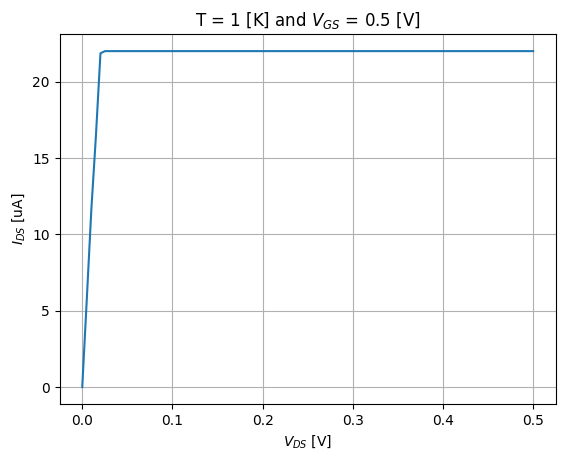

In [171]:
Vds_array, Ids_array = plot_IVds(
    T = 1,
    Vgs = 0.5
)

In [196]:
def get_IVds(Vgs_array,T, tol = 1e-2*q, lr = 0.005):
    
    Vds_array = np.linspace(0, 0.5, 25)
    # Vgs_array = [0.3, 0.35, 0.4, 0.45, 0.5]    
    
    output = []

       
    for Vgs in Vgs_array:
        U = -.3*q 
        Ids_array = []
        print(f"Computing for V_GS = {Vgs}\n")
        for i, Vds in enumerate(Vds_array):
            I, U_array  = solve_I(
                Vds = Vds,
                T = T,
                Vgs = Vgs,
                U_guess = U,
                lr = lr,
                tol = tol,
                disable=True
            )
            U = U_array[-1]
            Ids_array.append(I)

            print(f"{i+1}%", end='\r')
            
        output.append((Vds_array, Ids_array,Vgs))
    return output

def plot_IVds_data(data, T):
    plt.figure(figsize=(10,7))
    plt.title(f"Característica IV para T = {T} [K]")
    plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
    plt.xlabel(r"Drain Source bias $(V_{DS})$ [V]")
    plt.ylim(0,50)
    plt.grid()
    for Vds_array, Ids_array, Vgs in data:
        plt.plot(Vds_array, np.array(Ids_array)*1e6, label = f'Vgs: {Vgs} V')
    plt.legend()
    plt.show()


In [197]:
Vgs_array = [0.3, 0.35, 0.4, 0.45, 0.5]  
data_T1 = get_IVds(Vgs_array, T = 1)

Computing for V_GS = 0.3

Computing for V_GS = 0.35

Computing for V_GS = 0.4

Computing for V_GS = 0.45

Computing for V_GS = 0.5



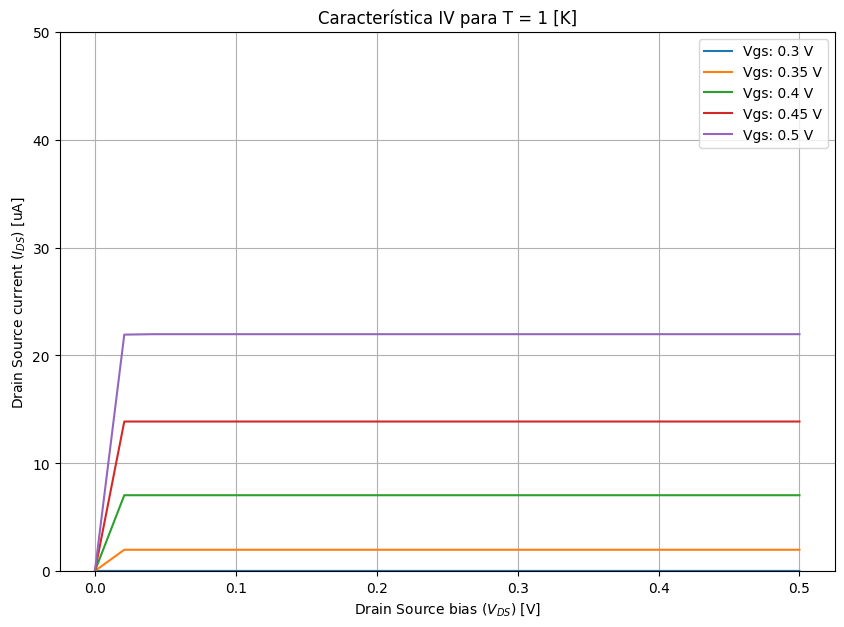

In [198]:
plot_IVds_data(data_T1, 1)

In [199]:
data_T298 = get_IVds(Vgs_array, T = 298)

Computing for V_GS = 0.3

Computing for V_GS = 0.35

Computing for V_GS = 0.4

Computing for V_GS = 0.45

Computing for V_GS = 0.5



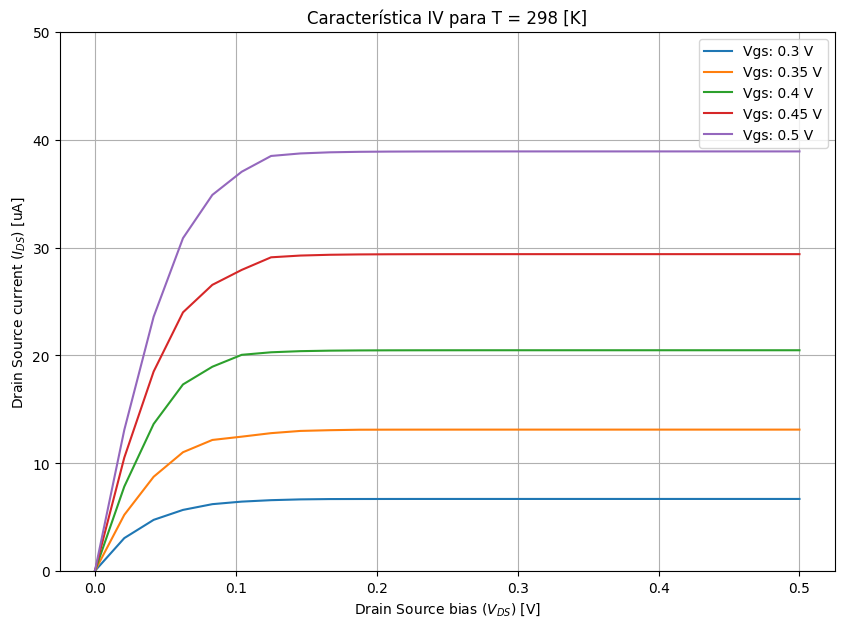

In [200]:
plot_IVds_data(data_T298, T = 298)

# Parte II

In [207]:
def I_lineal(Vds, V_gs): # eq 5.60
    cnt = q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    # print(np.sqrt(V_gs-V_t-Vds/eta)**3, np.sqrt(V_gs-V_t)**3, cnt, cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3))
    return cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3)


def I_saturado(V_gs): # eq 5.61
    cnt =  q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    return cnt*np.sqrt(V_gs-V_t)**3


# I_lineal = np.vectorize(I_lineal)
# I_saturado = np.vectorize(I_saturado)


In [215]:
Vds_array = np.linspace(0, 0.5, 1000)

def IVds_T0(Vgs, Vds_array):

    Ids_array = []

    for i, Vds in enumerate(Vds_array):
        if Vds < eta*(Vgs-V_t):
            I = I_lineal(Vds, Vgs)
        else:
            I = I_saturado(Vgs)
        Ids_array.append(I)
    
    return Ids_array

def get_IVds_T0(Vgs_array):

    data = []
    Vds_array = np.linspace(0, 0.5, 50)
    plt.figure()
    for Vgs in Vgs_array:
        Ids_array = IVds_T0(Vgs, Vds_array)
        data.append((Vds_array, Ids_array, Vgs))
    
    return data

In [310]:
V_t

3.599999999999995e-05

<Figure size 640x480 with 0 Axes>

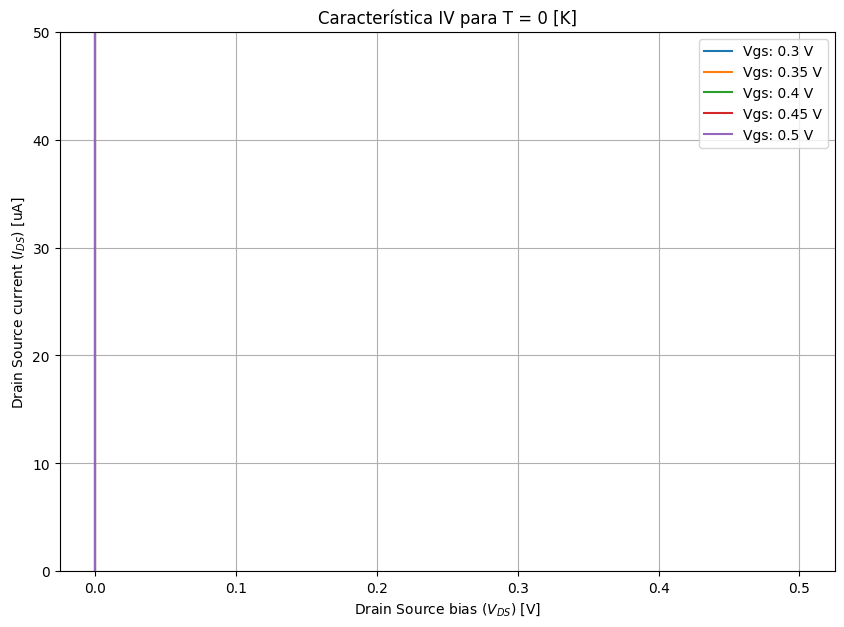

In [309]:
Vgs_array = [0.3, 0.35, 0.4,0.45, 0.5] 
data_T0 = get_IVds_T0(Vgs_array)
plot_IVds_data(data_T0, 0)

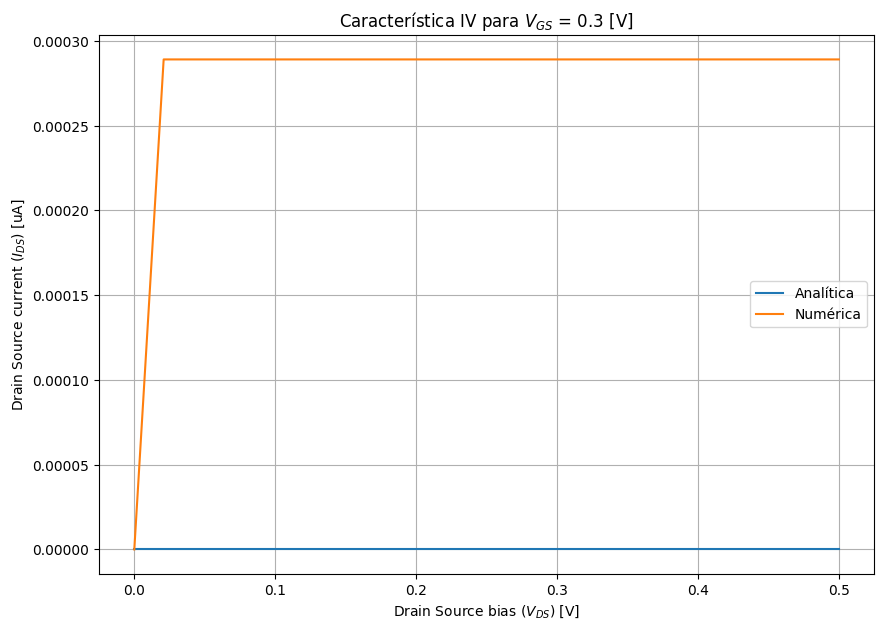

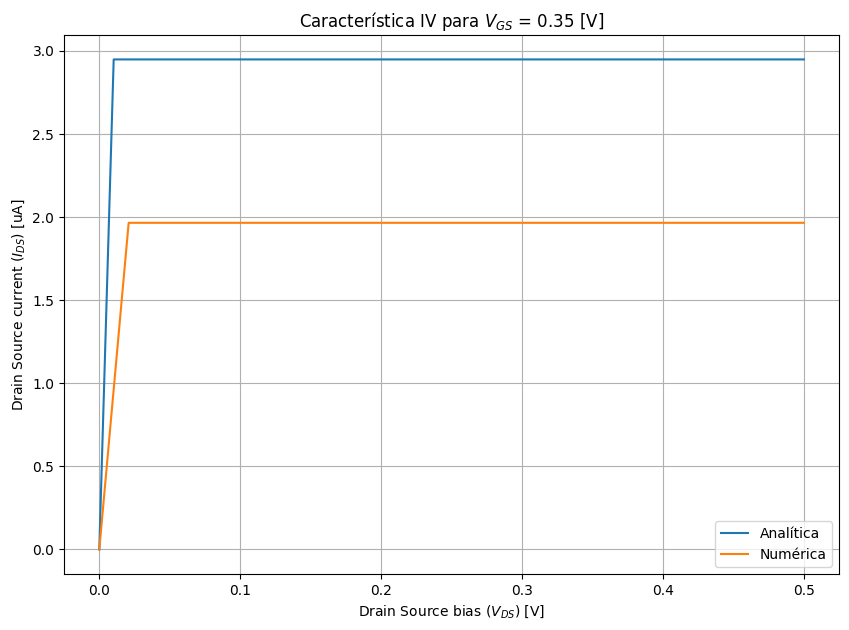

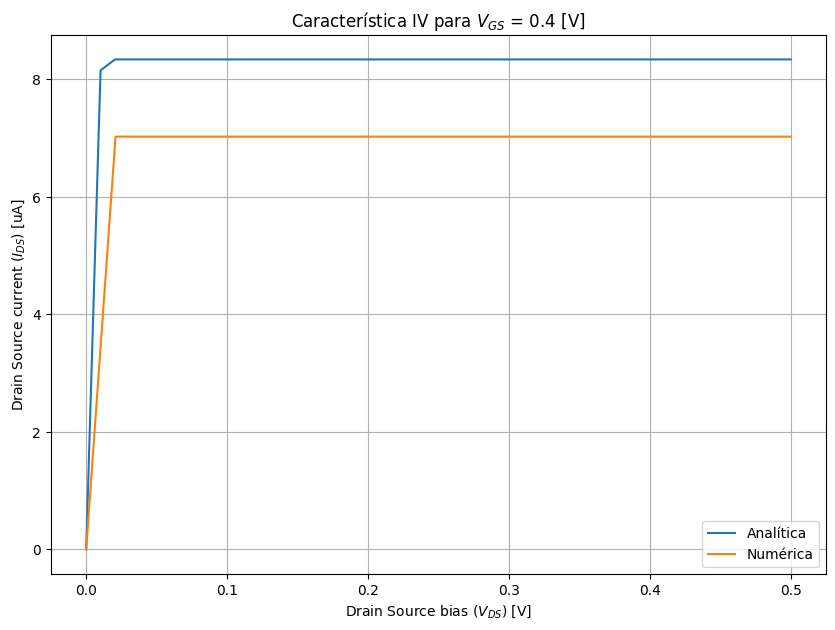

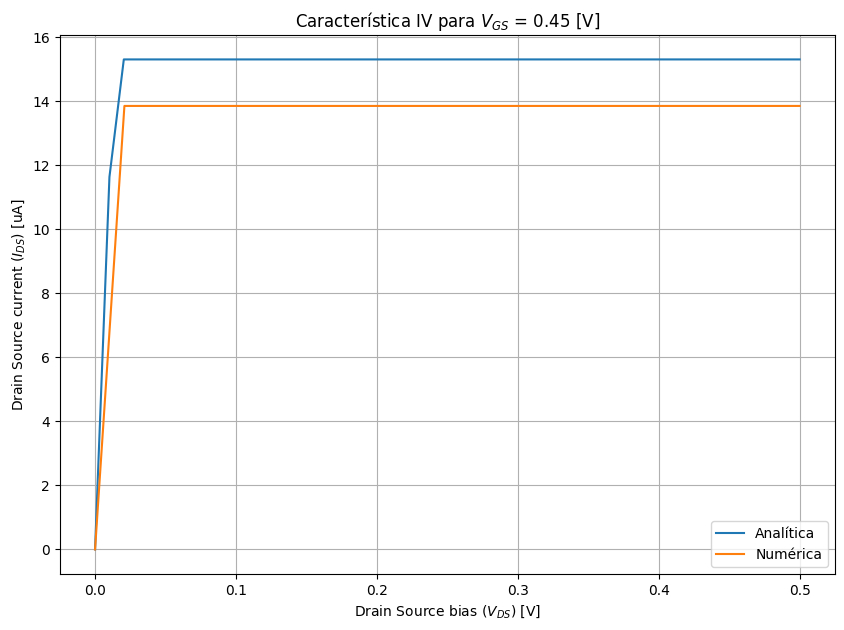

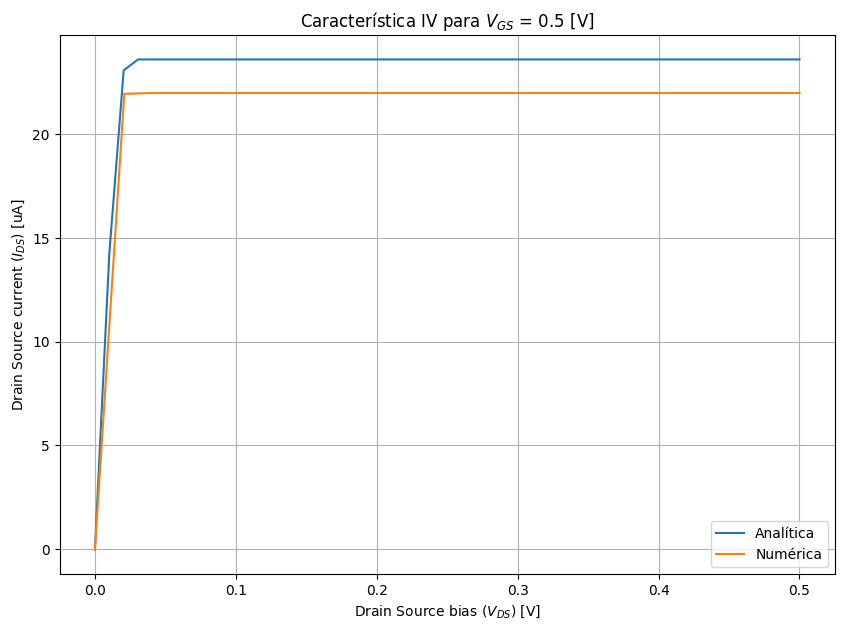

In [224]:

for i in range(len(data_T0)):
    Vds_array_T0, Ids_array_T0, Vgs_T0 = data_T0[i]
    Vds_array_T1, Ids_array_T1, Vgs_T1 = data_T1[i]

    assert Vgs_T0 == Vgs_T1

    plt.figure(figsize=(10,7))
    plt.title(f"Característica IV para {r'$V_{GS}$'} = {Vgs_T1} [V]")
    plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
    plt.xlabel(r"Drain Source bias $(V_{DS})$ [V]")
    # plt.ylim(0,50)
    plt.grid()
    # for Vds_array, Ids_array, Vgs in data:

    plt.plot(Vds_array_T0, np.array(Ids_array_T0)*1e6, label = f"Analítica")
    plt.plot(Vds_array_T1, np.array(Ids_array_T1)*1e6, label = f"Numérica")
    plt.legend()
    plt.show()

# Parte III

In [271]:
def IVgs(Vds, T, tol = 1e-4*q, lr = 0.005):
    n = 200
    
    Vgs_array = np.linspace(0, 0.5, n)

    Ids_array = []
    U = -1*q    
    for i, Vgs in enumerate(Vgs_array):
        I, U_array  = solve_I(
            Vds = Vds,
            T = T,
            Vgs = Vgs,
            U_guess = U,
            lr = lr,
            tol = tol,
            disable=True
        )
        U = U_array[-1]
        Ids_array.append(I)

        print(f"{int(100*(i+1)/n)}%", end='\r')

    return Vgs_array, np.array(Ids_array)

voltage, current = IVgs(0.5, 298)
    
    

KeyboardInterrupt: 

In [275]:
len(y)

100

In [283]:
for i, j in zip([x1, x2], [y1, y2]):
    print(i, j)

28.460534920572112 0.001
87.65023360420025 0.01


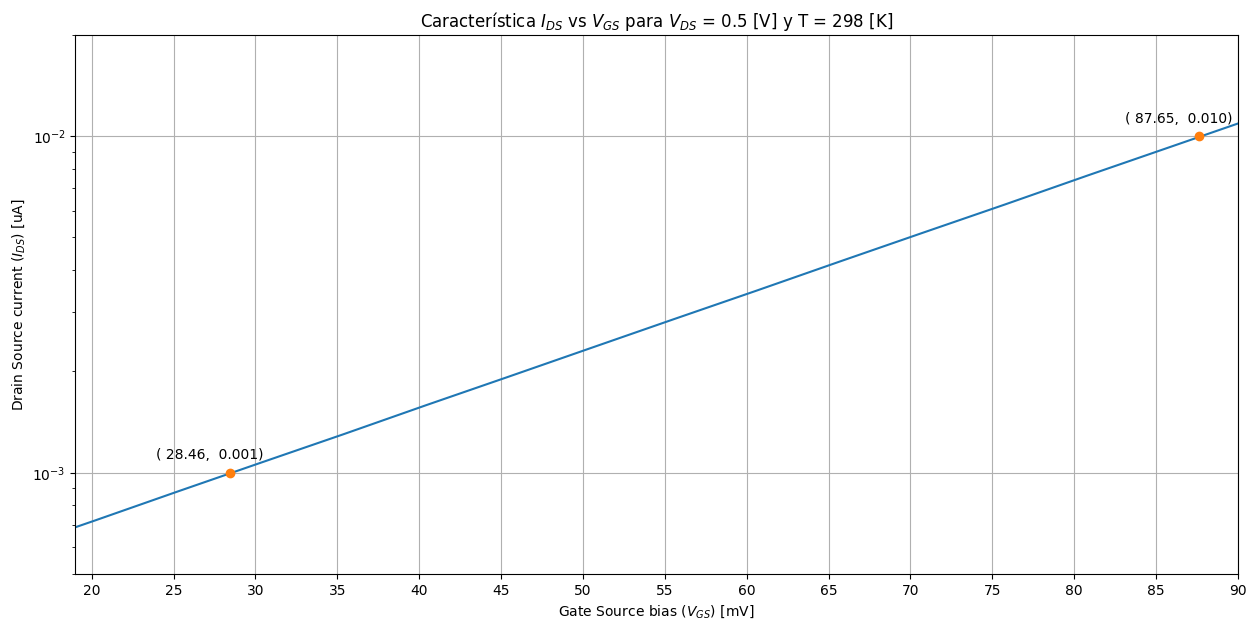

In [289]:
plt.figure(figsize=(15,7))

x = (voltage*1e3)
y = (current*1e6)

y1, y2 = 1e-3, 1e-2
x1, x2 = np.interp((y1, y2), y, x)

plt.plot(x, y)
plt.plot(cut_x, cut_y, 'o')
plt.title(f"Característica {r'$I_{DS}$'} vs {r'$V_{GS}$'} para {r'$V_{DS}$'} = {0.5} [V] y T = 298 [K]")
plt.xticks(np.arange(min(x), max(x)+1, 5.0))
plt.xlabel(r"Gate Source bias $(V_{GS})$ [mV]")
plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
plt.yscale('log')
plt.ylim(0.5e-3,2e-2)
plt.xlim(19,90)
for i, j in zip([x1, x2], [y1, y2]):
    plt.annotate(f'({i: .2f}, {j: .3f})', xy=(i, j), textcoords='offset points', xytext=(-15,10), ha='center')
plt.grid()
plt.show()


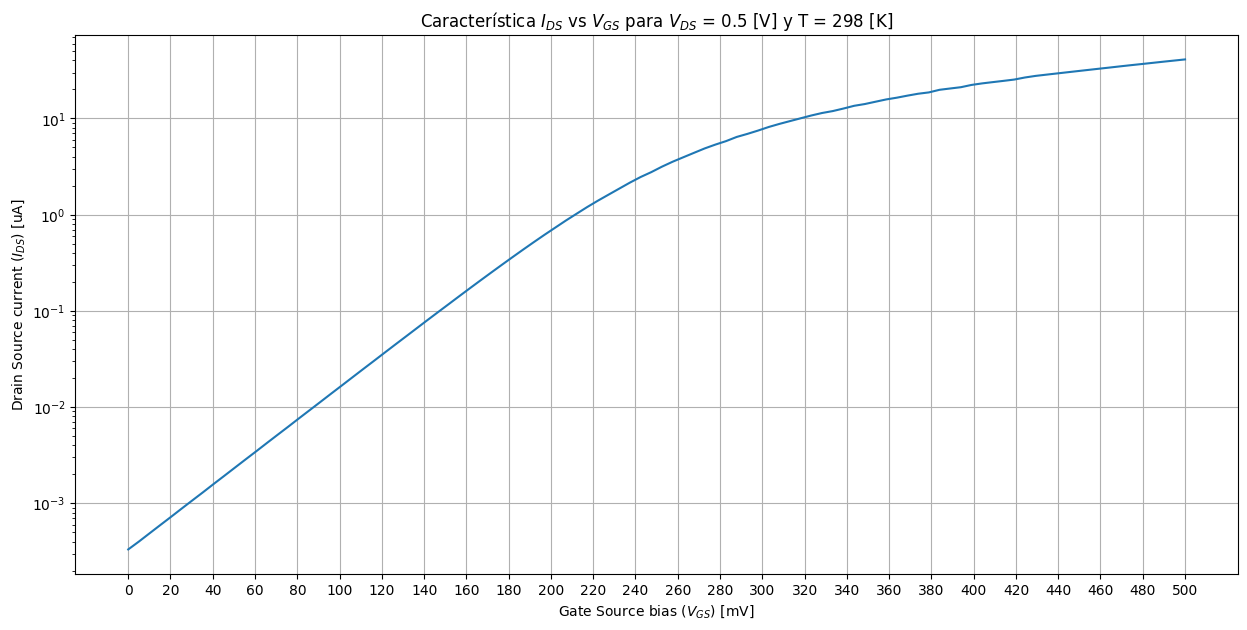

In [255]:
plt.figure(figsize=(15,7))
plt.plot(voltage*1e3, current*1e6)
plt.title(f"Característica {r'$I_{DS}$'} vs {r'$V_{GS}$'} para {r'$V_{DS}$'} = {0.5} [V] y T = 298 [K]")
plt.xticks(np.arange(min(voltage*1e3), max(voltage*1e3)+1, 20.0))
plt.xlabel(r"Gate Source bias $(V_{GS})$ [mV]")
plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
plt.yscale('log')
plt.grid()
plt.show()


# Parte IV

In [324]:

def plot_t0_t298_vt(data_T298, data_T0):
    fig, ax = plt.subplots(figsize=(17,10))
    for Vds_array, Ids_array, Vgs in data_T298:
        ax.plot(Vds_array, np.array(Ids_array)*1e6, label = f'Vgs: {Vgs} V')
    fig.gca().set_prop_cycle(None)
    for Vds_array, Ids_array, Vgs in data_T0:
        ax.plot(Vds_array, np.array(Ids_array)*1e6, ':', label = f'Vgs: {Vgs} V')

    ax.set_title(f"Característica IV para T = 0 [K] y T = 298 [K]; $V_T$ = {V_t: .3f} [V]")
    ax.set_ylabel(r"Drain Source current $(I_{DS})$ [uA]")
    ax.set_xlabel(r"Drain Source bias $(V_{DS})$ [V]")
    ax.set_ylim(0,50)    
    ax.grid()
    ax.legend()
    plt.show()




<Figure size 640x480 with 0 Axes>

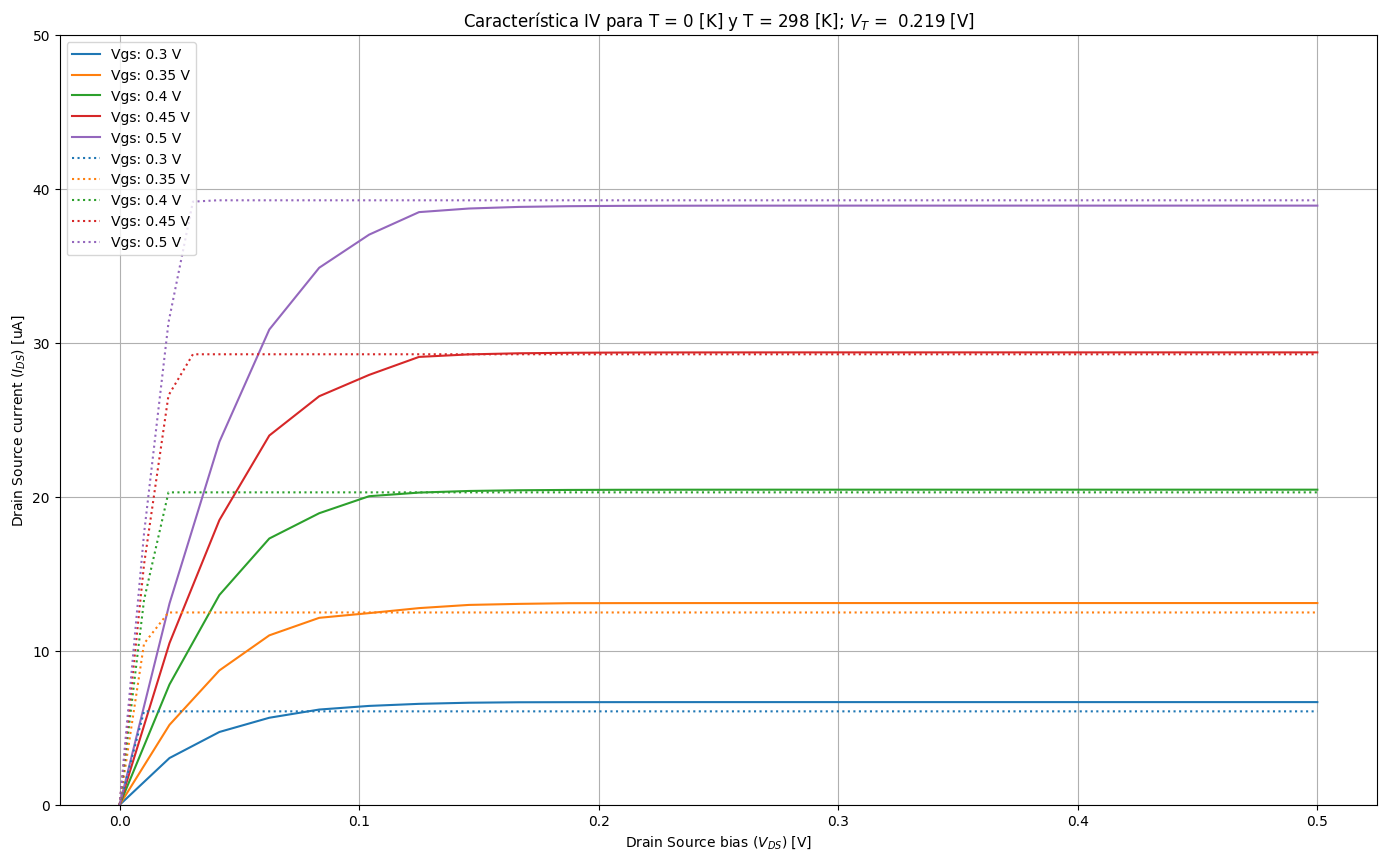

In [325]:

V_t = (Ec-Ef)/(q)*0.73
plot_t0_t298_vt(data_T298, get_IVds_T0(Vgs_array))